<a href="https://colab.research.google.com/github/jumbokh/nknu-class/blob/main/CNN/YOLO/08_07__Tensorflow_Yolov4_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 測試 TensorFlow YOLO4 格式檔

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -fs /content/gdrive/My\ Drive /app
%cd /app/DL_Book/src

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/app/My Drive': Input/output error
/content/gdrive/My Drive/DL_Book/src


In [2]:
# 載入套件
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import YOLO4.core.utils as utils
from YOLO4.core.yolov4 import YOLOv4, YOLOv3, YOLOv3_tiny, decode
from PIL import Image
import cv2
import numpy as np
import tensorflow as tf

In [3]:
# 設定 YOLO 模型參數
STRIDES = np.array([8, 16, 32])
ANCHORS = utils.get_anchors("./YOLO4/data/anchors/yolov4_anchors.txt", False)
NUM_CLASS = len(utils.read_class_names("./YOLO4/data/classes/coco.names"))
XYSCALE = [1.2, 1.1, 1.05]  # 縮放比例
input_size = 608
yolov4_weights_path = "./YOLO_weights/yolov4.weights"

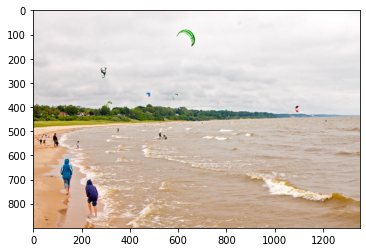

In [4]:
# 讀取測試影像
import matplotlib.pyplot as plt
image_path = './YOLO4/data/kite.jpg'
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]
plt.imshow(original_image)

# 前置處理
image_data = utils.image_preporcess(np.copy(original_image), 
                                    [input_size, input_size])
image_data = image_data[np.newaxis, ...].astype(np.float32)

In [5]:
# 結合模型結構與權重檔，建立模型
input_layer = tf.keras.layers.Input([input_size, input_size, 3])
feature_maps = YOLOv4(input_layer, NUM_CLASS)
bbox_tensors = []
for i, fm in enumerate(feature_maps):
    bbox_tensor = decode(fm, NUM_CLASS, i)
    bbox_tensors.append(bbox_tensor)
# 模型結構    
model = tf.keras.Model(input_layer, bbox_tensors)

# 載入權重
utils.load_weights(model, yolov4_weights_path)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 608, 608, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 608, 608, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

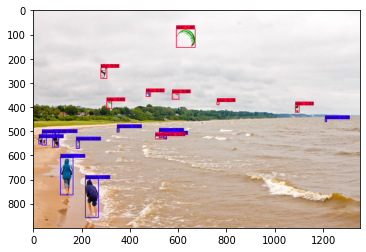

In [6]:
# 預測
pred_bbox = model.predict(image_data)

# 找出 Bounding Box
pred_bbox = utils.postprocess_bbbox(pred_bbox, ANCHORS, STRIDES, XYSCALE)
bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.25)

# 使用NMS，移除重疊的 Bounding Box
bboxes = utils.nms(bboxes, 0.213, method='nms')

# 原圖加框
image = utils.draw_bbox(original_image, bboxes)
image = Image.fromarray(image)

# 顯示結果
plt.imshow(image)
image.show()